# plot_ripple_trace

plot ripple example for figure 1

In [1]:
import pickle
import numpy as np
# plotting
from matplotlib import pyplot as plt
import dabest
import pandas as pd
from scipy import stats
import h5py
import sys,os
import glob
from ripple_detection import filter_ripple_band
from scipy import signal
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Continuous Wavelet Transform
import obspy
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt

import sys
sys.path.append("D:/ryanh/github/ripple_analyses")
from functions import *

from neurodsp.filt import filter_signal



Bad key "text.kerning_factor" on line 4 in
D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

%config InlineBackend.figure_format = 'retina'

## helper functions

In [32]:
def get_good_channels(shank):
    #extract values from dictionary
    an_array = np.array(list(shank.values()),dtype=object)
    
    #loop through array to pull out individual channel        
    good_ch = []
    for i in range(len(an_array)):
        for x in range(len(an_array[i])):
            good_ch.append(an_array[i][x])
        
    return good_ch


def get_lfp(df,i):
    data_path = 'F:\\Projects\\PAE_PlaceCell\\ProcessedData\\'

    # get data session path from mat file
    path = get_session_path(data_path+df.session[i]+'.mat')

    # load xml which has channel & fs info
    channels,fs,shank = loadXML(path)

    # get good channels
    good_ch = get_good_channels(shank)

    # load .lfp
    # lfp, ts = load_lfp(glob.glob(path +'\*.lfp')[0],channels,fs)
    lfp,ts = loadLFP(glob.glob(path +'\*.lfp')[0], n_channels=channels,
                     channel=good_ch, frequency=fs,
                     precision='int16')
    return lfp,ts

def normalize(list, range):
    l = np.array(list) 
    a = np.max(l)
    c = np.min(l)
    b = range[1]
    d = range[0]
    m = (b - d) / (a - c)
    pslope = (m * (l - c)) + d
    return pslope

def get_scalogram(sig,fs=1250,padding=100,f_min=150,f_max=250,fig=1,ax=0):
    
    # sample difference
    dt = 1/fs
    # pad signal
    sig_padded = np.pad(sig, (padding, padding), 'linear_ramp')
    # get time stamps
    t = np.linspace(0, dt * len(sig), len(sig))
    # get scalogram
    scalogram = cwt(sig_padded, dt, 8, f_min, f_max)
    # delete padding
    scalogram = np.delete(scalogram, np.s_[1:padding+1], axis=1) 
    scalogram = np.delete(scalogram, np.s_[-(padding+1):-1], axis=1) 
    
    # plot figure
    if fig==1:
        cmap = plt.get_cmap('magma')
        if ax == 0:
            fig = plt.figure()
            ax = fig.add_subplot(111)

        x, y = np.meshgrid(
            t,
            np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))

        im = ax.pcolormesh(x, y, np.abs(scalogram), cmap=cmap,shading='auto')
        ax.set_rasterized(True)
        ax.plot(t,normalize(sig,[f_min,f_max]),color='w',linewidth=1)
        ax.set_ylabel("Frequency [Hz]")
        ax.set_ylim(f_min, f_max)
        # ax.set_yscale('log')
        if ax == 0:
            plt.show()
    
    return np.abs(scalogram),im

## Load data

In [5]:
csv_path = 'F:/Projects/PAE_PlaceCell/analysis/swr_data/post_processed/'

df = pd.read_csv(csv_path+'swr_df.csv')
df

,Unnamed: 0,Unnamed: 0.1,ripple_number,start_time,end_time,ripple_duration,max_emg,peak_time,peak_channel,peak_amplitude,peak_freq,clipped,session,ep_type,group,area,ripple_duration_log10,peak_amplitude_log10
0,0,0,22,211.247200,211.327200,0.080000,0.990871,211.296000,3,5.566472,213.605249,0.000000,LEM3116_S20180715121821,track,control,ca1,-1.096910,0.745580
1,1,1,60,517.919200,518.311200,0.392000,0.995188,518.087200,7,29.168512,203.155556,0.000000,LEM3116_S20180715121821,track,control,ca1,-0.406714,1.464914
2,2,2,72,607.938400,608.326400,0.388000,0.990928,607.964000,3,7.932019,103.616382,0.000000,LEM3116_S20180715121821,track,control,ca1,-0.411168,0.899384
3,3,3,80,675.985600,676.139200,0.153600,0.994272,676.074400,7,5.077734,173.913383,0.000000,LEM3116_S20180715121821,track,control,ca1,-0.813609,0.705670
4,4,4,100,933.226400,933.424000,0.197600,0.992893,933.278400,7,27.285162,119.721685,0.000000,LEM3116_S20180715121821,pedestal_2,control,ca1,-0.704213,1.435927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17540,17540,17818,25,255.450400,255.599200,0.148800,0.314032,255.533600,7,8.094016,105.746020,0.000000,RH16_S20161126145021,track,pae,ca1,-0.827397,0.908164
17541,17541,17819,22,149.384000,149.505600,0.121600,0.133732,149.436800,6,12.060743,186.017137,0.000000,RH16_S20161126150318,track,pae,ca1,-0.915066,1.081374
17542,17542,17820,32,233.419200,233.576000,0.156800,0.260312,233.496000,7,8.145433,110.793201,0.000000,RH16_S20161126150318,track,pae,ca1,-0.804654,0.910914
17543,17543,17821,36,270.288000,270.410400,0.122400,0.065024,270.328800,0,4.390508,174.380797,0.000000,RH16_S20161126150318,track,pae,ca1,-0.912219,0.642515


# function to plot ripple examples

In [54]:
def plot_spectogram(rip_n,temp_df,idx,x_range,filtered_lfps,LFPs,ts,save_path):
    # set up figure
    fig = plt.figure(figsize=set_size('thesis',fraction=.5,subplots=(1,1)),constrained_layout=False)
    fig.subplots_adjust(hspace = 0, wspace=0.5)
    gs = fig.add_gridspec(3, 1)
    f_ax1 = fig.add_subplot(gs[0:2, :])
    f_ax2 = fig.add_subplot(gs[2, :])

    # plot scalogram
    _,im = get_scalogram(LFPs[idx,df.peak_channel[rip_n]],1250,f_min=80,f_max=350,ax=f_ax1)
    f_ax1.set_xlabel('time (sec)')
    f_ax1.get_xaxis().set_visible(False)

    # set up parameters for colorbar
    axins = inset_axes(f_ax1,
                       width="2%",  # width = 5% of parent_bbox width
                       height="100%",  # height : 50%
                       loc='lower left',
                       bbox_to_anchor=(1.02, 0., 1, 1),
                       bbox_transform=f_ax1.transAxes,
                       borderpad=0,
                       )
    # plot colorbar
    cbar = fig.colorbar(im,ax=f_ax1,cax=axins)
    cbar.set_label('Magnitude', rotation=270, labelpad=20)
    cbar.outline.set_visible(False)

    # plot filtered trace
    f_ax2.plot(ts[idx],filtered_lfps[idx,df.peak_channel[rip_n]],color='k',linewidth=0.8)
    for ripple in temp_df[(temp_df.peak_time >= df.peak_time[rip_n] - x_range/2) & (temp_df.peak_time <= df.peak_time[rip_n] + x_range/2)].itertuples():
        f_ax2.axvspan(ripple.start_time, ripple.end_time, alpha=0.2, color='red', zorder=-1000) # #fec287

    f_ax2.autoscale(enable=True, axis='x', tight=True)

    # align x axis
    locs = f_ax2.get_xticks()
    labels = f_ax2.get_xticklabels()
    f_ax2.set_xticks(np.linspace(min(ts[idx]), max(ts[idx]), 5))
    f_ax2.set_xticklabels(np.linspace(-x_range/2,x_range/2,5))

    # name x axis
    f_ax2.set_xlabel('time (sec)')

    # clean up y axis and box
    f_ax2.get_yaxis().set_visible(False)
    right_side = f_ax2.spines["right"]
    right_side.set_visible(False)
    left_side = f_ax2.spines["left"]
    left_side.set_visible(False)
    top_side = f_ax2.spines["top"]
    top_side.set_visible(False)

    # save plot
    # plt.savefig('ripple_trace_spectro.svg',dpi=900,bbox_inches='tight')
    if not os.path.exists(save_path+df.group[rip_n]+df.area[rip_n]+'_ripple_examples'):
        os.mkdir(save_path+df.group[rip_n]+df.area[rip_n]+'_ripple_examples')
        
    plt.savefig(save_path+df.group[rip_n]+df.area[rip_n]+'_ripple_examples/ripple_trace_spectro_'+str(rip_n)+'.png',dpi=900,bbox_inches='tight')
    plt.savefig(save_path+df.group[rip_n]+df.area[rip_n]+'_ripple_examples/ripple_trace_spectro_'+str(rip_n)+'.svg',dpi=900,bbox_inches='tight')

## Chose ripple number, load data, and plot example ripple

In [38]:
# rip_n = 21568
# rip_n = 21682
rip_n = 6313
lfp,ts = get_lfp(df,rip_n)

filtered_lfps = np.array([filter_signal(lfp_,1250,'bandpass',(80,250),remove_edges=False) for lfp_ in lfp.T])
filtered_lfps = filtered_lfps.T

# LFPs = lfp
# filtered_lfps = np.stack([filter_ripple_band(lfp, 1250) for lfp in LFPs.T])
# filtered_lfps = filtered_lfps.T

x_range = .200
idx = (ts >= df.peak_time[rip_n] - x_range/2) & (ts <= df.peak_time[rip_n] + x_range/2)
temp_df = df[df.session == df.session[rip_n]]

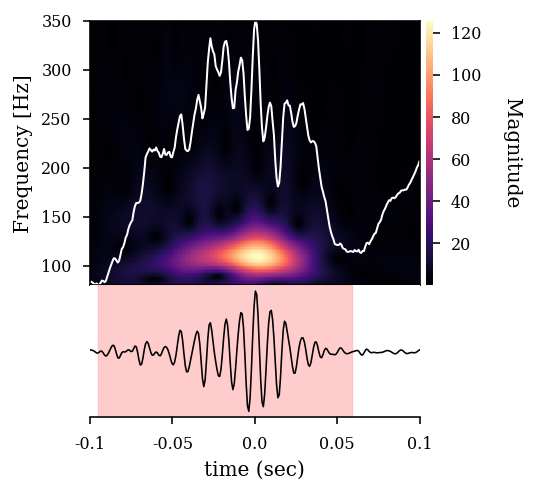

In [40]:
save_path = 'D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/ripple_section/'
plot_spectogram(rip_n,temp_df,idx,x_range,filtered_lfps,lfp,save_path)

# run through each ripple with the below parameters

In [ ]:
def get_example_idx(df,group,area,frac_std=1):
    idx = (df.group == group) & (df.area == area)
    # get median values
    ripple_duration = np.median(df.ripple_duration[idx])
    ripple_duration_std = np.std(df.ripple_duration[idx]) * frac_std

    peak_freq = np.median(df.peak_freq[idx])
    peak_freq_std = np.std(df.peak_freq[idx]) * frac_std

    peak_amplitude = np.median(df.peak_amplitude[idx])
    peak_amplitude_std = np.std(df.peak_amplitude[idx]) * frac_std

    idx = ((df.group == group)
        & (df.area == area)
        & (df.ripple_duration > ripple_duration-ripple_duration_std)
        & (df.ripple_duration < ripple_duration+ripple_duration_std)
        & (df.peak_freq > peak_freq-peak_freq_std)
        & (df.peak_freq < peak_freq+peak_freq_std)
        & (df.peak_amplitude > peak_amplitude-peak_amplitude_std)
        & (df.peak_amplitude < peak_amplitude+peak_amplitude_std))

    return idx

def run_though_idx(df,idx):
    save_path = 'D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/ripple_section/'

    for rip_n in df[idx].index:
        lfp,ts = get_lfp(df,rip_n)

        filtered_lfps = np.array([filter_signal(lfp_,1250,'bandpass',(80,250),remove_edges=False) for lfp_ in lfp.T])
        filtered_lfps = filtered_lfps.T

        x_range = .200
        idx = (ts >= df.peak_time[rip_n] - x_range/2) & (ts <= df.peak_time[rip_n] + x_range/2)
        temp_df = df[df.session == df.session[rip_n]]

        plot_spectogram(rip_n,temp_df,idx,x_range,filtered_lfps,lfp,ts,save_path)
    
idx = get_example_idx(df,'control','ca1',frac_std=.25)
run_though_idx(df,idx)

idx = get_example_idx(df,'pae','ca1',frac_std=.25)
run_though_idx(df,idx)

idx = get_example_idx(df,'control','ca3',frac_std=.25)
run_though_idx(df,idx)

idx = get_example_idx(df,'pae','ca3',frac_std=.25)
run_though_idx(df,idx)


In [36]:
idx = (df.ripple_duration > .1) & (df.ripple_duration < .200) & (df.group == 'control') & (df.peak_amplitude > 5) & (df.peak_amplitude < 15) & (df.peak_freq > 105) & (df.peak_freq < 115)
df[idx]

,Unnamed: 0,Unnamed: 0.1,ripple_number,start_time,end_time,ripple_duration,max_emg,peak_time,peak_channel,peak_amplitude,peak_freq,clipped,session,group,ep_type
63,63,66,170,650.3032,650.4104,0.1072,0.546901,650.3216,3,9.902439,113.984711,0.006667,LEM3116_S20180716174306,control,pedestal_2
71,71,75,281,1956.0328,1956.1352,0.1024,0.495027,1956.0880,0,13.331721,105.383303,0.006667,LEM3116_S20180716174306,control,pedestal_3
82,82,86,370,2728.4608,2728.6016,0.1408,0.663184,2728.5256,7,6.163021,113.394550,0.000000,LEM3116_S20180716174306,control,cylinder_2
652,652,660,378,4771.6920,4771.8488,0.1568,0.418471,4771.7184,5,10.271730,109.852273,0.006667,LEM3116_S20180718184628,control,cylinder_2
1032,1032,1044,224,726.8448,726.9848,0.1400,0.522006,726.8744,7,8.555035,108.540252,0.006667,LEM3116_S20180808160117,control,pedestal_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17286,17286,17564,187,1278.1512,1278.3376,0.1864,0.435741,1278.2080,2,7.603517,106.871739,0.000000,LS23_S20170428111117,control,cylinder_1
17298,17298,17576,53,188.3736,188.5344,0.1608,0.241261,188.4176,2,7.797524,111.298185,0.000000,LS23_S20170502130551,control,track
17304,17304,17582,74,254.2640,254.4384,0.1744,0.202877,254.2944,2,6.685304,113.042035,0.000000,LS23_S20170502130551,control,track
17339,17339,17618,497,1629.6856,1629.8560,0.1704,0.182385,1629.7440,2,12.667969,114.757107,0.000000,LS23_S20170502130551,control,cylinder_1


In [ ]:
from IPython.display import display, clear_output

# idx = (df.ripple_duration > .05) & (df.ripple_duration < .07) & (df.group == 'control') & (df.peak_amplitude > 5) & (df.peak_freq > 200) & (df.peak_freq < 230)
idx = (df.ripple_duration > .1) & (df.ripple_duration < .200) & (df.group == 'control') & (df.peak_amplitude > 5) & (df.peak_amplitude < 15) & (df.peak_freq > 105) & (df.peak_freq < 115)

for rip_n in df[idx].index:
    lfp,ts = get_lfp(df,rip_n)

    filtered_lfps = np.array([filter_signal(lfp_,1250,'bandpass',(80,250),remove_edges=False) for lfp_ in lfp.T])
    filtered_lfps = filtered_lfps.T
    
    x_range = .200
    idx = (ts >= df.peak_time[rip_n] - x_range/2) & (ts <= df.peak_time[rip_n] + x_range/2)
    temp_df = df[df.session == df.session[rip_n]]
    
    plot_spectogram(rip_n,temp_df,idx,x_range,filtered_lfps,lfp,save_path)
    clear_output()

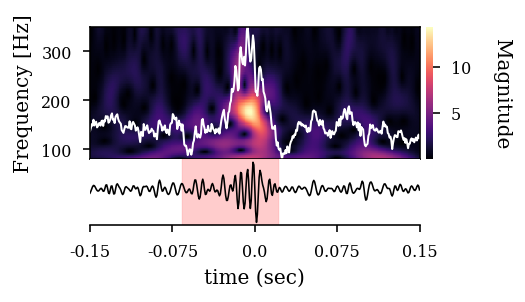

In [58]:
rip_n = 17058
rip_n = 5707
rip_n = 12339
rip_n = 3034

lfp,ts = get_lfp(df,rip_n)

filtered_lfps = np.array([filter_signal(lfp_,1250,'bandpass',(80,250),remove_edges=False) for lfp_ in lfp.T])
filtered_lfps = filtered_lfps.T

x_range = .300
idx = (ts >= df.peak_time.iloc[rip_n] - x_range/2) & (ts <= df.peak_time.iloc[rip_n] + x_range/2)
temp_df = df[df.session == df.session.iloc[rip_n]]

save_path = 'D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/ripple_section/'

plot_spectogram(rip_n,temp_df,idx,x_range,filtered_lfps,lfp,ts,save_path)
